# Plate based size exclusion simulation and analysis notebook

## Simulate a single pbSEC run

In [2]:
from pbsec import pbSEC

pbsec_parameters = dict(
    p0=10,  # Protein concentration
    l0=8,  # Ligand concentration
    kdpl=10,  # Protein-ligand complex KD
    recovery_efficiency=1.0,  # Fraction efficiency - 90 % recovery efficiency is denoted by a value of 0.9
)
print(f"Using the following parameters: {pbsec_parameters}")
simulation_result = pbSEC(**pbsec_parameters)
# Simulate a single pbSEC run with 100 % efficiency
print(f"Amount complex (also amount ligand) = {simulation_result}")

Using the following parameters: {'p0': 10, 'l0': 8, 'kdpl': 10, 'recovery_efficiency': 1.0}
Amount complex (also amount ligand) = 3.229670385730992


## Simulate pbSEC iterations
Iterations of pbSEC may be performed by passing eluant from one run to the next

In [4]:
from pbsec import pbSEC_simulate_n_rounds

pbsec_parameters = dict(
    p0=10,  # Protein concentration
    l0=8,  # Ligand concentration
    kdpl=10,  # Protein-ligand complex KD
    recovery_efficiency=1.0,  # Fraction efficiency - 90 % recovery efficiency is denoted by a value of 0.9
    num_iterations=10,  # Number of pbSEC iterations
)

print(f"Using the following parameters: {pbsec_parameters}")
simulation_result = pbSEC_simulate_n_rounds(**pbsec_parameters)
print(
    f"Amount complex (also amount ligand) at each iteration = {simulation_result}",
)

Using the following parameters: {'p0': 10, 'l0': 8, 'kdpl': 10, 'recovery_efficiency': 1.0, 'num_iterations': 10}
Amount complex (also amount ligand) at each iteration = [3.229670385730992, 1.485289660112462, 0.7151066803602028, 0.3511631623450422, 0.17404025537442974, 0.08664150972365803, 0.04322692091197959, 0.021590103399623268, 0.010789225044449048, 0.0053931574301171415]


## Simulate iterative pbSEC runs until instrument detection limit is reached

Perform iterative pbSEC runs using protein and ligand with known KD and iterate
until the specified detection limit is reached.

In [5]:
from pbsec import pbSEC_iterate_until_undetectable

pbsec_parameters = dict(
    p0=10,  # Protein concentration
    l0=8,  # Ligand concentration
    kdpl=10,  # Protein-ligand complex KD
    recovery_efficiency=1.0,  # Fraction efficiency - 90 % recovery efficiency is denoted by a value of 0.9
    l_detection_limit=0.001,  # Ligand detection limit
)
print(f"Using the following parameters: {pbsec_parameters}")
simulation_result = pbSEC_iterate_until_undetectable(**pbsec_parameters)
print(
    f"Amount complex (also amount ligand) at each of {len(simulation_result)} iterations = {simulation_result}"
)

Using the following parameters: {'p0': 10, 'l0': 8, 'kdpl': 10, 'recovery_efficiency': 1.0, 'l_detection_limit': 0.001}
Amount complex (also amount ligand) at each of 12 iterations = [3.229670385730992, 1.485289660112462, 0.7151066803602028, 0.3511631623450422, 0.17404025537442974, 0.08664150972365803, 0.04322692091197959, 0.021590103399623268, 0.010789225044449048, 0.0053931574301171415, 0.002696215138226855, 0.0013480166994129454]


## Plot pbSEC rounds, pKd vs concentration

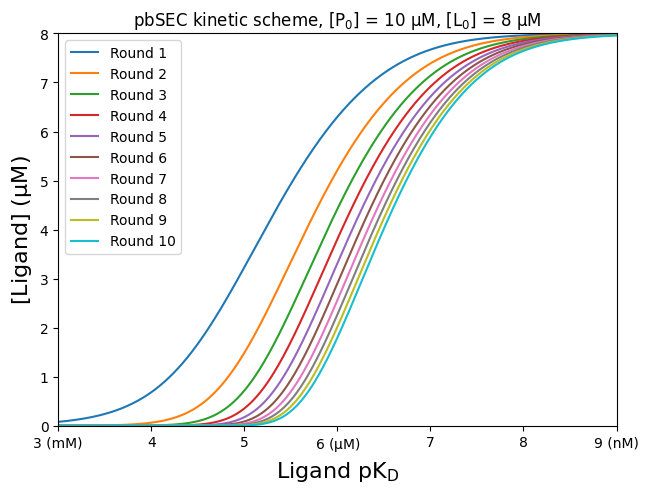

In [11]:
import numpy as np
from pbsec import pbSEC_simulate_n_rounds
import matplotlib.pyplot as plt

XAXIS_BEGINNING = 3  # pKD of 3 is 1 mM
XAXIS_END = 9  # pKD of 12 is 1 pM
NUM_POINTS_ON_XAXIS = 2000  # Publication used 2000 pts along X
PROTEIN_CONC = 10.0
LIGAND_CONC = 8.0  # Singular compound conc in pool
NUM_ROUNDS = 10
RECOVERY_EFFICIENCY = 1.0

x_axis = np.linspace(XAXIS_BEGINNING, XAXIS_END, NUM_POINTS_ON_XAXIS)
ligand_kd_range = 10 ** (-x_axis) * 1e6
protein_concs = np.full((NUM_ROUNDS, NUM_POINTS_ON_XAXIS), np.nan)

for kd_i, kd in enumerate(ligand_kd_range):
    protein_concs[:, kd_i] = pbSEC_simulate_n_rounds(
        PROTEIN_CONC,
        LIGAND_CONC,
        kd,
        NUM_ROUNDS,
        recovery_efficiency=RECOVERY_EFFICIENCY,
    )

fig, ax = plt.subplots(1, 1, figsize=(7.204724, 5.09424929292))

for i in range(NUM_ROUNDS):
    ax.plot(x_axis, protein_concs[i], label="Round " + str(i + 1))
# ax.hlines(1,3,9)
plt.legend()

ax.set_xticks(
    range(XAXIS_BEGINNING, XAXIS_END + 1),
    ["3 (mM)", "4", "5", r"6 ($\mathrm{\mu}$M)", "7", "8", "9 (nM)"],
)
ax.set_xlim(3, 9)
ax.set_ylim(0, 8)
ax.set_xlabel(r"Ligand pK$_\mathrm{D}$", fontsize=16)
ax.set_ylabel(r"[Ligand] ($\mathrm{\mu}$M)", fontsize=16)
ax.set_title(
    r"pbSEC kinetic scheme, [P$_0$] = 10 $\mathrm{\mu}$M, [L$_0$] = 8 $\mathrm{\mu}$M"
)
plt.show()

## Plot pbSEC rounds, recovery efficiency vs log complex

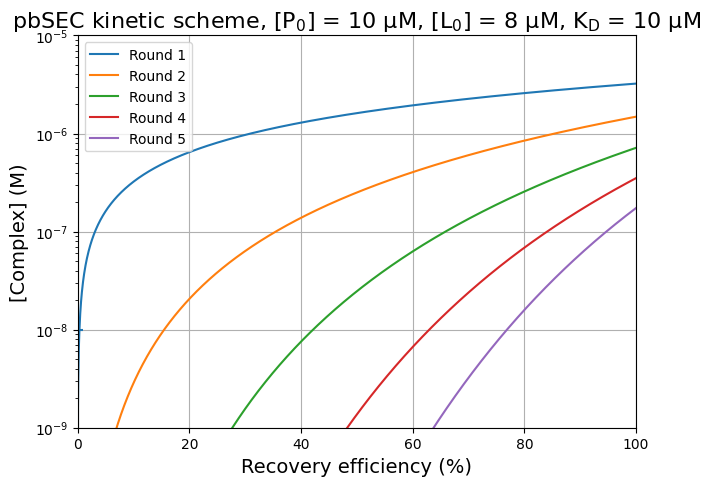

In [12]:
import numpy as np
from pbsec import pbSEC_simulate_n_rounds
import matplotlib.pyplot as plt

XAXIS_BEGINNING = 0  # pKD of 3 is mM
XAXIS_END = 100  # pKD of 12 is pM
YAXIS_BEGINNING = 1e-3
YAXIS_END = 10
NUM_POINTS_ON_XAXIS = 2000  # Publication used 2000 pts along X
PROTEIN_CONC = 10.0
LIGAND_CONC = 8.0  # Singular compound conc in pool
KD = 10  # 1 µM
NUM_ROUNDS = 5

x_axis = np.linspace(XAXIS_BEGINNING, XAXIS_END, NUM_POINTS_ON_XAXIS)
# ligand_kd_range = 10**(-x_axis)*1e6
ligand_concs = np.full((NUM_ROUNDS, NUM_POINTS_ON_XAXIS), np.nan)

for efficiency_i, efficiency in enumerate(x_axis / 100.0):
    ligand_concs[:, efficiency_i] = pbSEC_simulate_n_rounds(
        PROTEIN_CONC, LIGAND_CONC, KD, NUM_ROUNDS, recovery_efficiency=efficiency
    )

ligand_concs *= 1e-6

fig, ax = plt.subplots(1, 1, figsize=(7.204724, 5.09424929292))

for i in range(NUM_ROUNDS):
    ax.plot(x_axis, ligand_concs[i], label="Round " + str(i + 1))
ax.hlines(1e-8, 0, 1)
plt.legend()
plt.yscale("log")
ax.set_xlim(0, 100)
ax.set_ylim(1e-9, 1e-5)
plt.grid(True)
# L,B,R,T
ax.set_xlabel(r"Recovery efficiency (%)", fontsize=14)
ax.set_ylabel(r"[Complex] (M)", fontsize=14)
ax.set_title(
    r"pbSEC kinetic scheme, [P$_0$] = 10 $\mathrm{\mu}$M, [L$_0$] = 8 $\mathrm{\mu}$M, K$_\mathrm{D}$ = "
    + str(KD)
    + " µM",
    fontsize=16,
)
plt.show()

## Plot pbSEC rounds, pKd vs num rounds detectable for

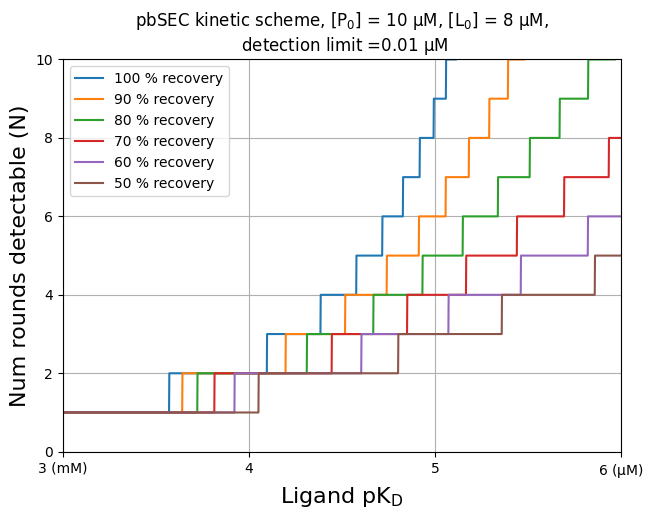

In [18]:
import numpy as np
from pbsec import pbSEC_iterate_until_undetectable
import matplotlib.pyplot as plt

XAXIS_BEGINNING = 3  # pKD of 3 is 1 mM
XAXIS_END = 6  # pKD of 12 is 1 pM
NUM_POINTS_ON_XAXIS = 2000  # Publication used 2000 pts along X
PROTEIN_CONC = 10.0
LIGAND_CONC = 8.0  # Singular compound conc in pool
RECOVERY_EFFICIENCIES = np.arange(1.0, 0.4, -0.1)
L_DETECTION_LIMIT = 0.01


x_axis = np.linspace(XAXIS_BEGINNING, XAXIS_END, NUM_POINTS_ON_XAXIS)
ligand_kd_range = 10 ** (-x_axis) * 1e6
num_iterations_taken = np.empty(
    (len(RECOVERY_EFFICIENCIES), NUM_POINTS_ON_XAXIS), dtype=int
)

for recovery_efficiency_i, recovery_efficiency in enumerate(RECOVERY_EFFICIENCIES):
    for kd_i, kd in enumerate(ligand_kd_range):
        num_iterations_taken[recovery_efficiency_i, kd_i] = len(
            pbSEC_iterate_until_undetectable(
                PROTEIN_CONC,
                LIGAND_CONC,
                kd,
                L_DETECTION_LIMIT,
                recovery_efficiency=recovery_efficiency,
            )
        )

fig, ax = plt.subplots(1, 1, figsize=(7.204724, 5.09424929292))

for recovery_efficiency_i, recovery_efficiency in enumerate(RECOVERY_EFFICIENCIES):
    ax.plot(
        x_axis,
        num_iterations_taken[recovery_efficiency_i],
        label=f"{recovery_efficiency*100:2.0f} % recovery",
    )
plt.legend()

ax.set_xticks(
    range(XAXIS_BEGINNING, XAXIS_END + 1),
    ["3 (mM)", "4", "5", r"6 ($\mathrm{\mu}$M)"],
)
# ax.set_xticks(range(XAXIS_BEGINNING, XAXIS_END+1))
ax.set_xlim(XAXIS_BEGINNING, XAXIS_END)
ax.set_ylim(0, 10)
# plt.yscale('log')
plt.grid(True)
ax.set_xlabel(r"Ligand pK$_\mathrm{D}$", fontsize=16)
ax.set_ylabel(r"Num rounds detectable (N)", fontsize=16)
ax.set_title(
    "pbSEC kinetic scheme, [P$_0$] = 10 $\mathrm{\mu}$M, [L$_0$] = 8 $\mathrm{\mu}$M,\n detection limit ="
    + str(L_DETECTION_LIMIT)
    + " $\mathrm{\mu}$M"
)
plt.show()

## Plot pbSEC conc vs recovery vs pKD

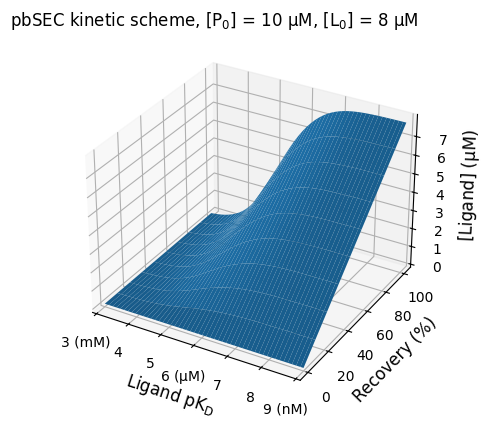

In [17]:
import numpy as np
from pbsec import pbSEC_simulate_n_rounds
import matplotlib.pyplot as plt

XAXIS_BEGINNING = 3  # pKD of 3 is 1 mM
XAXIS_END = 9  # pKD of 12 is 1 pM
NUM_POINTS_ON_XAXIS = 200  # Publication used 2000 pts along X
PROTEIN_CONC = 10.0  # Protein concentration
LIGAND_CONC = 8.0  # Singular compound conc in pool
NUM_ROUNDS = 1  # Simulate only 1 round
RECOVERY_EFFICIENCY_START = 0
RECOVERY_EFFICIENCY_END = 100
recovery_efficiencies = np.linspace(
    RECOVERY_EFFICIENCY_START, RECOVERY_EFFICIENCY_END, num=10
)


x_axis = np.linspace(XAXIS_BEGINNING, XAXIS_END, NUM_POINTS_ON_XAXIS)
ligand_kd_range = 10 ** (-x_axis) * 1e6
protein_concs = np.empty(
    (NUM_ROUNDS, recovery_efficiencies.shape[0], NUM_POINTS_ON_XAXIS)
)

for recovery_efficiency_i, recovery_efficiency in enumerate(recovery_efficiencies):
    for kd_i, kd in enumerate(ligand_kd_range):
        protein_concs[:, recovery_efficiency_i, kd_i] = pbSEC_simulate_n_rounds(
            PROTEIN_CONC,
            LIGAND_CONC,
            kd,
            NUM_ROUNDS,
            recovery_efficiency=recovery_efficiency,
        )
# fig = plt.figure(figsize=(10,10))
# # ax = fig.add_subplot(111, projection="3d")
# fig = plt.figure()
# ax = fig.gca(projection='3d')
protein_concs *= 1e-2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x_axis, recovery_efficiencies)
Z = np.full(X.shape, np.nan)
for round in reversed(range(NUM_ROUNDS)):
    for i in range(x_axis.shape[0]):
        for j in range(recovery_efficiencies.shape[0]):
            Z[j][i] = protein_concs[round, j, i]
    ax.plot_surface(X, Y, Z, label="Round " + str(round + 1))

ax.set_xticks(
    np.arange(XAXIS_BEGINNING, XAXIS_END + 1),
    ["3 (mM)", "4", "5", r"6 ($\mathrm{\mu}$M)", "7", "8", "9 (nM)"],
)
ax.set_xlim(3, 9)
ax.set_xlabel(r"Ligand pK$_\mathrm{D}$", fontsize=12)
ax.set_ylabel(r"Recovery (%)", fontsize=12)
ax.set_zlabel(r"[Ligand] ($\mathrm{\mu}$M)", fontsize=12)
ax.set_title(
    "pbSEC kinetic scheme, [P$_0$] = 10 $\mathrm{\mu}$M, [L$_0$] = 8 $\mathrm{\mu}$M              "
)
plt.show()